In this notebook, we will go through an end to end machine learning project, making use of the Kmeans clustering algorithm to cluster customers into different segments

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
import math

In [ ]:
customer_segment = pd.read_csv("../input/customer-segmentation/ELD Service Provider Segmentation Dataset.csv")

# Data Exploration

Lets start off by exploring the contents of the dataset using the head() mehtod. This will output the first 5 rows giving a glimpse into the columns and thier values 

In [ ]:
customer_segment.head()

Before moving on and analyzing the dataset, lets make sure that the data types for each column are correct

In [ ]:
customer_segment.dtypes

As you can see the customer date is of the type object. However we would want to convert it to a datetime data type. We will use the pandas to_datetime method to convert the column to the relevant data type

In [ ]:
customer_segment['Customer Date'] =  pd.to_datetime(customer_segment['Customer Date'], infer_datetime_format=True)

Before we move on, lets extract some useful information from the Customer Date column. We can extract the year, the month, and the year-month. These might be useful later on

In [ ]:
customer_segment['month_year'] = customer_segment['Customer Date'].dt.to_period('M')
customer_segment['year'] = pd.DatetimeIndex(customer_segment['Customer Date']).year
customer_segment['month'] = pd.DatetimeIndex(customer_segment['Customer Date']).month
customer_segment.head()

Let's now get some basic statistical details about our data. We will use the pandas descirbe() method to get information such as mean, std, min, max etc for all the numerical attributes in our data. We will use the transpose() method in conjunction just so that its a bit easier to read

In [ ]:
customer_segment.describe().transpose()

## Numercial Attributes exploration

We will start start off by exploring the Net ARR variable.To see the distribution of the attribute we will use the displot which is part of the seabporn library

In [ ]:
sns.displot(customer_segment['Net ARR']);

As you can see from the graph above and from the skewness and Kurtosis, that this variable is not normally distributed. If we choose to incorporate this in our clustering analysis we will need to fit this to a normal distribution. We will go into more details on this later on

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % customer_segment['Net ARR'].skew())
print("Kurtosis: %f" % customer_segment['Net ARR'].kurt())

Another very informative view of the data is through the use of multiple histograms within one visualization. This helps you get a good idea about how the frequency of the data is distributed among different values that an attribute can take

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
customer_segment.hist(figsize = (50,20))
plt.show()

A few comments about the hisgrams:
* The attributes have different scales. While the number of ELD devices and the Composite Fleet size, do take the same scale, the NETT ARR attribute is different since it represents the dollar amounts that the company is earning
* The histograms for ELD, CFS (Composite Fleet Size) and Net ARR are tail heavy, meaning that they could be hard for some machine learning algorithms to detect patterns. We will try transforming these attributes later on to have a more bell-shaped distribution

## Categorical Attributes Exploration

In this section we will be exploring some of the categorical attributes present in the data. We will be using the boxplot to get information on the categorical attributes. 

A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed. 

The Image below summarizes the usefulness of the boxplot:

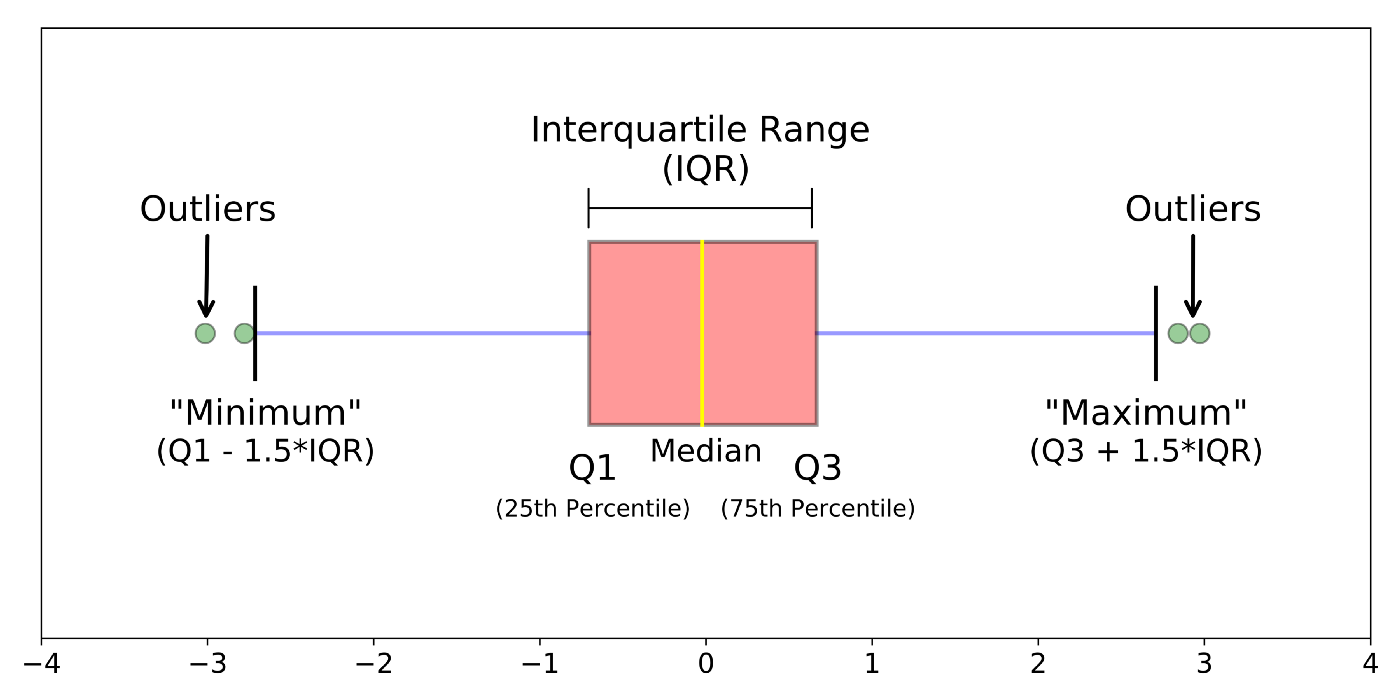

*important note: boxplot image and boxplot description has been taken from the following article: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

In [ ]:
var = 'Segment'
data = pd.concat([customer_segment['Composite Fleet Size'], customer_segment[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Composite Fleet Size", data=data)
fig.axis(ymin=0, ymax=1000);

In [ ]:
var = 'Segment'
data = pd.concat([customer_segment['Net ARR'], customer_segment[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="Net ARR", data=data)
fig.axis(ymin=0, ymax=2500000);

Segment here represnts the way the customers are currently being segmented

An important things to notice from these boxplots:
* Since we know that the Composite Fleet Size is being used to determine the segments, the boxplot should indicate a difference in the values in distribution of segments on Net ARR and on the Composite Fleet Size. However, lookinmg at the data we see some overlap. Segmenting customers should rely on differentiating them as much as we can in order to target them accordingly. We therefore need to improve on the way the segments are being created


In [ ]:
var = 'Territory'
data = pd.concat([customer_segment['Net ARR'], customer_segment[var]], axis=1)
f, ax = plt.subplots(figsize=(100, 10))
fig = sns.boxplot(x=var, y="Net ARR", data=data)
fig.axis(ymin=0, ymax=300000);

In [ ]:
sns.lineplot(data=customer_segment, x="year", y="Net ARR")

#  Data Cleaning

With the data we have, an important thing to check are the number of records that have a value of zero. Technically 0 should not be in our dataset for Net ARR or Number of ELD devices since we are assuming that the customers we have are paying customers which have bought atleast one ELD device from the company. We will therefore check the value of 0 for both these attributes one by one

Here I will use two methods to remove the 0 values:

* For the attribute, Number of ElD Devices, I will convert the 0 values to nan, then use the Composite Fleet Size column to look at similar values that were not 0 or blank and use average of those values to fill the current 0/nan values
* For the Net ARR, I wil keep things simple and just drop all rows that have a 0

In [ ]:
customer_segment[customer_segment['Number of ELD Devices']==0]

In [ ]:
customer_segment["Number of ELD Devices"].replace(0, np.nan, inplace=True)
#customer_segment["Number of ELD Devices"].fillna(customer_segment.groupby("Composite Fleet Size")["Number of ELD Devices"].transform("mean"))
customer_segment['Number of ELD Devices'] = customer_segment.groupby(['Composite Fleet Size'], sort=False)['Number of ELD Devices'].apply(lambda x: x.fillna(x.mean())).round().astype(int)

In [ ]:
customer_segment[customer_segment['Net ARR']==0].count()

In [ ]:
#customer_segment["Net ARR"].replace(0, np.nan, inplace=True)
#customer_segment['Net ARR'] = customer_segment.groupby(['Composite Fleet Size'], sort=False)['Net ARR'].apply(lambda x: x.fillna(x.mean())).round()
#customer_segment.groupby(['Composite Fleet Size'], sort=False)['Net ARR'].apply(lambda x: x.fillna(x.mean()))
customer_segment = customer_segment[customer_segment['Net ARR'] != 0]

Most Machine Learning algorithms cannot work with missing features. You have three options when dealing with missing features:
* Get rid of the corresponding values
* Get rid of the whole attribute
* Set the values to some value( zero, the mean, the median etc)

We will start with looking at the number of values that are null. We will then take the percentage of those values with respect to the total sample for that particular attribute to see how many values are missing

In [ ]:
total = customer_segment.isnull().sum().sort_values(ascending=False)
percent = (customer_segment.isnull().sum()/customer_segment.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0]
missing_data

As we can see from the table above, there is only one value missing. 

* Since Net ARR is an indicator that a customer is a paying customer, we will drop where its null assuming that we will not consider customers that are not paying

In [ ]:
customer_segment = customer_segment[customer_segment['Net ARR'].notna()]

In [ ]:
total = customer_segment.isnull().sum().sort_values(ascending=False)
percent = (customer_segment.isnull().sum()/customer_segment.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0]
missing_data

# Looking for Correlations

You can easily compute the the standard correlation coefficient (also called the Pearson's r) between every pair of attributes using the corr() method.

After getting the correlation values, lets look at how each attribute correlates with the 'Net ARR'

In [ ]:
corr_matrix = customer_segment.corr()
corr_matrix["Net ARR"].sort_values(ascending = False)

The correlation coefficient ranges from -1 to 1. When it is close to 1, it means there is a strong positive correlation. When the correaltion is close to -1, it means there is a strong negative correlation

Another way to check for correlation between attributes is to use the pairplot function, which plots every numercial attribute against each other numerical attribute. 

In [ ]:
sns.set()
sns.pairplot(customer_segment, height = 2.5)
plt.show();

Some important observations from the correlation coefficient and the pairplot:

* The most correlated variable with Net ARR is the number of ELD devices which makes sense since the more devices you sell the more revenue you earn. 
* However, Composite Fleet Size does not indicate a very strong relation with Net ARR. Which means that even if the customer has a lot of trucks in their fleet, they are still not buying a lot of ELD's from our company

Note that these are very important observations. Composite Fleet Size is currently being used to segment customers. However, that variable is not a very strong indicator of the revenue the company is earning. We need to think of other features that could better help us capture the segments in terms of revenue capitalization because in the end, as a business, they are concerned the most about revenue

Let's look at the the composite fleet size and number of ELD devices individually with Net ARR. just to get more information regarding the datapoints

In [ ]:
var = 'Composite Fleet Size'
data = pd.concat([customer_segment['Net ARR'], customer_segment[var]], axis=1)
data.plot.scatter(x=var,xlim = (0,2000), y='Net ARR', ylim=(0,800000));

In [ ]:
var = 'Number of ELD Devices'
data = pd.concat([customer_segment['Net ARR'], customer_segment[var]], axis=1)
data.plot.scatter(x=var,xlim = (0,2000), y='Net ARR', ylim=(0,800000));

Finally, we can use a vey useful visualization to show the correlation between nunmerical attributes; the seaborn heatmap visualization.

In [ ]:
corrmat = customer_segment.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Net ARR')['Net ARR'].index
cm = np.corrcoef(customer_segment[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Experimenting with Attribute Combinations

We have seen so far that the composite fleet size by itself would not be an ideal attribute to segment the customer on. For one, it fails to truly reflect the customers, e.g there could be two customers with huge fleet sizes however one of them could be purchasing a lot from us and the other not so much and therefore the strategy to deal with them would be different. Hence, we need to add more attributes to our model

Lets copy the original data and add additional features to this copied dataset

In [ ]:
update_segments = customer_segment.copy()

Now one important attribue that we need to derive is the potencial of upselling to an exisiting customer. This means that we need to see as to how many trucks the compnay has and how many ELD devices the customer is currently purchashing from us. Note that here I am assuming that each truck would have one ELD device. 

To calculate the Potencial Upsell ACV we will need to derive other variables before computing that:

In [ ]:
update_segments['ARR/Product'] = update_segments['Net ARR'].floordiv(update_segments['Number of ELD Devices'])

In [ ]:
update_segments['Potencial Upsell Product'] = update_segments['Composite Fleet Size'] - update_segments['Number of ELD Devices']

In [ ]:
update_segments.head()

Note that the relationship in the exisiting data between the number of trucks and the Number of ELD devices is not one to one. However, to make things simpler, we will assume that if a customer is purchashing more devices than the number of trucks they have then we do not have any additional upsell potencial there. 

We will therefore change all negative values in the "Potencial Upsell Product" to 0

In [ ]:
update_segments.loc[update_segments['Potencial Upsell Product'] < 0, 'Potencial Upsell Product'] = 0

Finally, using the attriubutes that we have derived, we can now calculate the Potenciall Upsell revenue. 

Note that there is one more attribute that I am deriving, the Potenciall ARR Achieved. Basically, I am assuming that we can get 70 % of the potencial revenue from the customer. Now the '70%' itrself is completely arbitrary and I have chosen this just to show that we can also use a historical analysis of how much we upsell on averge and use that to segment customers. However, for our analysis, we will be sticking with the Potencial Upsell Product ARR (represnting all the revenue that we can achieve based on the assumptions mentioned above). 

In [ ]:
update_segments['Potencial Upsell Product ARR'] = update_segments['ARR/Product'] * update_segments['Potencial Upsell Product']
update_segments['Potencial ARR Achieved'] = update_segments['Potencial Upsell Product ARR'] * 0.70
update_segments['Potencial ARR Achieved'] = update_segments['Potencial ARR Achieved'].astype('int64')

In [ ]:
update_segments['Current/Potencial ARR'] =  update_segments['Potencial Upsell Product ARR'] + update_segments['Net ARR']

Let's now briefly go through the same process of exploring the dataset with new features. Note that since they have been derived from existing information, we do not need to go through the whole process again. We will just look at the summary statistics and general correlation between variables in this section before diving into our model

In [ ]:
update_segments.head()

In [ ]:
corr_matrix1 = update_segments.corr()
corr_matrix1["Net ARR"].sort_values(ascending = False)

In [ ]:
corrmat1 = update_segments.corr()
k = 8 #number of variables for heatmap
cols = corrmat1.nlargest(k, 'Net ARR')['Net ARR'].index
cm = np.corrcoef(update_segments[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
update_segments.describe().round().transpose().astype(int)

# Preparing Data for Machine Learning

## Feature Selection

We will now select the features that we want to use to segment our customers: 

Based on our exploration, we decided that instead of just using the composite fleet size attribute, we need more information to better segment our customers. We therefore derived the Potencial Upsell revenue feature that would tell us which customers we can upsell to. Lastly we will use the Net ARR feature as its a good indicator to the amount of revenue each customer is bringing to the company and will be crucial in resource allocation as a ratio of revenue 

In [ ]:
segment_final = pd.DataFrame(update_segments[['Potencial Upsell Product ARR','Net ARR','Composite Fleet Size']].copy().astype(np.int32))

In [ ]:
segment_final[segment_final['Net ARR'] == 0]

In [ ]:
segment_final.describe().round().transpose().astype(int)

## Normalization

We mentioned earlier that the attributes we have are not normally distributed which is essential for K-means clustering. We will therefore go ahead and use the yeojohnson function to normalize all the three features that we have selected

In [ ]:
def yeojohnson(x):
    xt, _= stats.yeojohnson(x)
    return xt

segment_boxcox = segment_final.apply(yeojohnson,axis = 0)

In [ ]:
segment_boxcox.describe().astype(int)

In [ ]:
sns.distplot(segment_boxcox['Net ARR'] , fit = norm)
fig = plt.figure()

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % segment_boxcox['Net ARR'] .skew())
print("Kurtosis: %f" % segment_boxcox['Net ARR'] .kurt())

In [ ]:
sns.distplot(segment_boxcox['Potencial Upsell Product ARR'] , fit=norm);
fig = plt.figure()

In [ ]:
print("Skewness: %f" % segment_boxcox['Potencial Upsell Product ARR'] .skew())
print("Kurtosis: %f" % segment_boxcox['Potencial Upsell Product ARR'] .kurt())

In [ ]:
sns.distplot(segment_boxcox['Composite Fleet Size'] , fit=norm);
fig = plt.figure()

In [ ]:
print("Skewness: %f" % segment_boxcox['Composite Fleet Size'] .skew())
print("Kurtosis: %f" % segment_boxcox['Composite Fleet Size'] .kurt())

## Feature Scaling 

One of the most important transformations you need to apply to your data is feature scaling. Machine learning algorithms don't work really well when the input numerical attributes have different scales.

We will use standardization wich subtracts the mean ( so standardized vales always have a 0 mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. We will import StandardScaler from Sicikit Learn to do the standardization. 

In [ ]:
scaler = StandardScaler()
scaler.fit(segment_boxcox)
segment_scaled = scaler.transform(segment_boxcox)
segment_scaled_df = pd.DataFrame(data = segment_scaled, index = segment_boxcox.index, columns = segment_boxcox.columns)

segment_scaled_df.agg(['mean','std']).round()

# Training the Model - K-Means 

We will again use Scikit-learn package to import Kmeans. To start off, we will be choosing 4 clusters for our model to divide our data in. We can provide this information to the Kmeans function as n_clusters = x number of clusters. We then fit the scaled and normalized data to the kmeans fit method which computes the clusters. In just a few lines of code we have gotten our clustering model

In [ ]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters = 4)
kmeans.fit(segment_scaled_df)
segment_kmeans4 = segment_final.assign(segment = kmeans.labels_)
Segments_refined = update_segments.assign(segment = kmeans.labels_)

# K - Means output

To see some basic properties of the segments that we have created using kmeans clustering we will use the groupby method on the clusters and get mean and count for each feature that we used in our model. 

This gives us a basic idea of each cluster. 

In [ ]:
segment_kmeans4.groupby(['segment']).agg({
    'Net ARR': ['mean','count'],
    'Potencial Upsell Product ARR' : ['mean','count'],
    'Composite Fleet Size' : ['mean','count']
    
}).round()

This is similar to what we did above but this time we are outputting it in terms of a visualization which is much easier to read

In [ ]:
kmeans4_averages = segment_kmeans4.groupby(['segment']).mean().round(0)
sns.heatmap(kmeans4_averages.T, cmap='YlGnBu')
plt.show()

Now we will compute the snake plot, which I think is one of the most useful charts for kmeans clustering since it tells you for each cluster, which features contributed the most

In [ ]:
segment_scaled_dff = pd.DataFrame(segment_scaled, index=segment_final.index, columns=segment_final.columns)
segment_scaled_dff['Cluster'] = segment_kmeans4['segment']
df_melt = pd.melt(segment_scaled_dff.reset_index(), id_vars = ['Cluster'],value_vars = ['Composite Fleet Size','Net ARR','Potencial Upsell Product ARR'],var_name = 'Attribute',value_name = 'Value')

In [ ]:
plt.figure(figsize=(15,16))
sns.lineplot(x = "Attribute",y = "Value",hue = 'Cluster', data = df_melt)

Some important observations about the information in the snake plot above:

* Cluster 0: represents customers that have a smaller fleet size but we are catering to almost all of their trucks since the potencial to upsell to them is minimal
* Cluster 1: represents customers that have a medium sized fleet size but again we are catering to all of their trucks and hence the upsell potencial is negligible
* Cluster 2: represents customers  that have a smaller fleet size, however they are not purchashing all ELD devices from us and therefore they have an uposell potencial
* Cluster 3: represents customers that have medium to large fleet sizes, however again the potencial to sell more to these customers is high as can be seen from the above chart 

Note that the way I have attributed customer fleet sizes to different clusters depends on the statistics we caluclated previously for the averge values of each feature for each cluster




We can also use a 3D Scatter plot to see how our clusters are divided. This provides a very good idea as to how good your Kmeans model was since by looking at the values you can see how far apart they are

In [ ]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

PLOT = go.Figure()

for C in list(segment_scaled_dff.Cluster.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = segment_scaled_dff[segment_scaled_dff.Cluster == C]['Composite Fleet Size'],
                                y = segment_scaled_dff[segment_scaled_dff.Cluster == C]['Net ARR'],
                                z = segment_scaled_dff[segment_scaled_dff.Cluster == C]['Potencial Upsell Product ARR'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'segment ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Composite Fleet Size', titlefont_color = 'black'),
                                yaxis=dict(title = 'Net ARR', titlefont_color = 'black'),
                                zaxis=dict(title = 'Potencial Upsell Product ARR', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

## Optimal Number of Clusters

Finally, we need to see as to what the ideal number of clusters should be. We can use the elbow method to derive the optimal number of clusters but one thing important to keep in mind is that it is highly encouraged to not just rely on this method but to use domain and bussiness knowledge to come up with the ideal number of clusters

In [ ]:
sse ={}
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state =1)
    kmeans.fit(segment_scaled_df)
    sse[k] = kmeans.inertia_

In [ ]:
plt.title('TheElbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

As we can see from the above char, 4 is the ideal number of clusters that the Elbow method is suggesting. In our case both the elbow method and the domain knwledge does give evidence to using 4 cliusters. 

Finally we will groupby the newly created segments and then get summary statistics on actual data and not scaled or normalized data for all the features that we used to get a sense of what kind of customer is in each cluster

In [ ]:
Segments_refined.groupby('segment')[['Net ARR','Composite Fleet Size','Potencial Upsell Product ARR']].describe(include=[np.number]).round().transpose()